In [1]:
!wget https://osf.io/download/crgu8/ -O ./tmp/test.pairs

--2023-12-18 23:04:28--  https://osf.io/download/crgu8/
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/638ue/providers/osfstorage/623993788d53ef082867e2b9 [following]
--2023-12-18 23:04:28--  https://files.de-1.osf.io/v1/resources/638ue/providers/osfstorage/623993788d53ef082867e2b9
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 

302 Found
Location: https://storage.googleapis.com/cos-osf-prod-files-de-1/b72f21bb7e21d00541fb3cbc50ef77d67b75970f7d255912ca527fb4c8e5cc0a?response-content-disposition=attachment%3B%20filename%3D%22test_pairs.wp-all.pairs%22%3B%20filename%2A%3DUTF-8%27%27test_pairs.wp-all.pairs&GoogleAccessId=files-de-1%40cos-osf-prod.iam.gserviceaccount.com&Expires=1702937129&Signature=0tM4rWv5RPZjFTYCKzHNbOZoInW3EOidpN5eHp1mlQv%2BWxUbUQ%2BqHDqVmJB4afWQ9CeQpovADOp%2BHNDVxr4GhotEENmyAd7GGdoGRkS%2FeSXM3G1hLxR5H3S5kBWfTVk57pRUXu%2FNj%2FZXOTJo5zKizIdmYlpPZ%2BDZZJvfXuExR3G6OWXcM3P7ufpFe6d53ZxiqpyhxIKVOU4uYo7zwFyxxofGrd5DONsz53sEH15S%2Fc84emZrxaFiQW5%2FEaupoEtLJQHcFc5au3fh8wApS4gtTU%2FDkINvnkyEDXyxND7%2FJDfQ0xJRRjelDXuFVHHDxbIqIfVhQnFK0QMEmlyoBLax1g%3D%3D [following]
--2023-12-18 23:04:29--  https://storage.googleapis.com/cos-osf-prod-files-de-1/b72f21bb7e21d00541fb3cbc50ef77d67b75970f7d255912ca527fb4c8e5cc0a?response-content-disposition=attachment%3B%20filename%3D%22test_pairs.wp-all.pairs%22%3B%20filenam

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker 
import matplotlib.gridspec 

%matplotlib inline
plt.style.use('seaborn-poster')

import pairtools
import pairtools.lib.scaling as scaling
import bioframe

In [4]:
pairs_path = './tmp/test.pairs'

In [5]:
mm10_chromsizes = bioframe.fetch_chromsizes('mm10', as_bed=True)
mm10_arms = mm10_chromsizes

# hg38_chromsizes = bioframe.fetch_chromsizes('hg38', as_bed=True)
# hg38_cens = bioframe.fetch_centromeres('hg38')
# hg38_arms = bioframe.split(hg38_chromsizes, hg38_cens, cols_points=['chrom', 'mid'])

In [6]:
cis_scalings, trans_levels = scaling.compute_scaling(
                pairs_path,
                regions=mm10_arms,
                chromsizes=mm10_chromsizes,
                dist_range=(10, 1000000000), 
                n_dist_bins_decade=8,
                chunksize=int(1e7),
                #cmd_in="gzip -dc "
            )

# calculate average trans contact frequency _per directionality pair_
# convert from int to float64 to avoid overflow
avg_trans = (
    trans_levels.n_pairs.astype('float64').sum() 
    / trans_levels.n_bp2.astype('float64').sum()
)


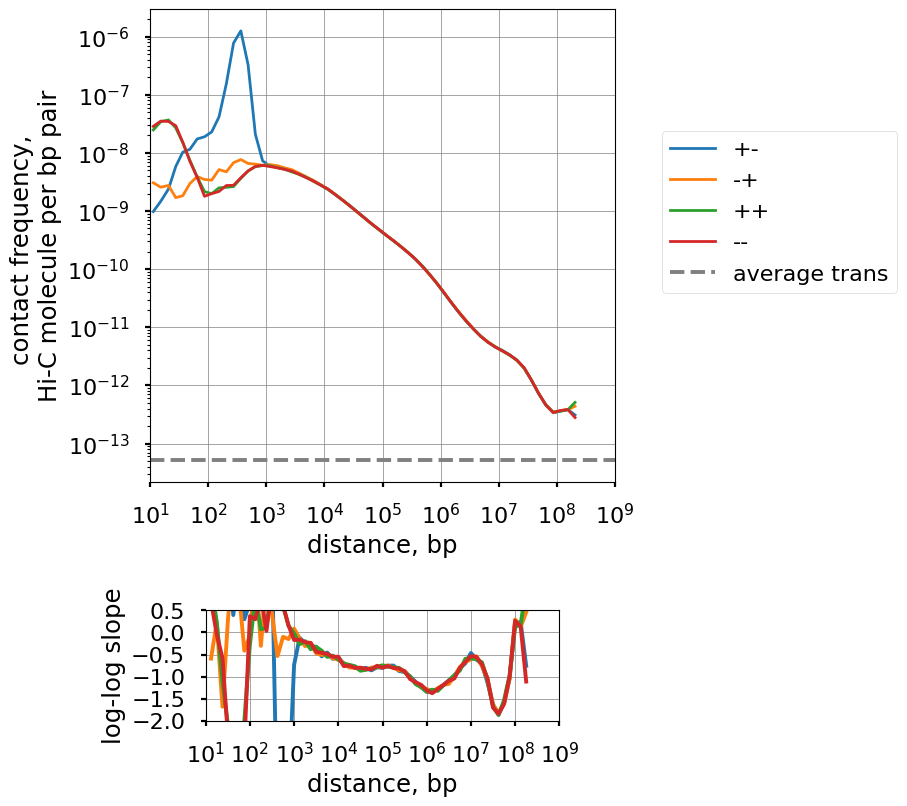

In [7]:
fig = plt.figure(figsize=(6,10))
gs = matplotlib.gridspec.GridSpec(2,1, height_ratios=[8, 1.5])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

strand_gb = cis_scalings.groupby(['strand1', 'strand2'])
for strands in ['+-', '-+', '++', '--']:
    sc_strand = strand_gb.get_group(tuple(strands))
    sc_agg = (sc_strand
        .groupby(['min_dist','max_dist'])
        .agg({'n_pairs':'sum', 'n_bp2':'sum'})
        .reset_index())

    dist_bin_mids = np.sqrt(sc_agg.min_dist * sc_agg.max_dist)
    pair_frequencies = sc_agg.n_pairs / sc_agg.n_bp2
    mask = pair_frequencies>0
    label = f'{strands[0]}{strands[1]}'

    ax1.loglog(
        dist_bin_mids[mask],
        pair_frequencies[mask],
        label=label,
        lw=2
    )

    ax2.semilogx(
        np.sqrt(dist_bin_mids.values[1:]*dist_bin_mids.values[:-1]),
        np.diff(np.log10(pair_frequencies.values)) / np.diff(np.log10(dist_bin_mids.values)),
        label=label
    )
    
ax1.axhline(avg_trans, ls='--', c='gray', label='average trans')

plt.sca(ax1)
plt.gca().set_aspect(1.0)
plt.gca().xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0,numticks=20))
plt.gca().yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0,numticks=20))
plt.xlim(1e1,1e9)
# plt.ylim(avg_trans / 3, plt.ylim()[1])

plt.grid(lw=0.5,color='gray')
plt.legend(loc=(1.1,0.4))
plt.ylabel('contact frequency, \nHi-C molecule per bp pair')
plt.xlabel('distance, bp')

plt.sca(ax2)
plt.xlim(1e1,1e9)
plt.ylim(-2,0.5)
plt.gca().set_aspect(1.0)
plt.ylabel('log-log slope')    
plt.xlabel('distance, bp')

plt.yticks(np.arange(-2,0.6,0.5))
plt.gca().xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0,numticks=20))
plt.grid(lw=0.5,color='gray')

# fig.tight_layout()

